In [2]:
import os
from typing import List, Union
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.pipeline import Pipeline
from pickle import dump, load

In [3]:
class PcaDetector(object):
    def __init__(self, model_directory: str, model_file_name: str):
        """
        PCA 모델을 초기화하거나 새롭게 생성하는 클래스
        model_directory (string): 모델이 저장된 디렉터리 경로
        model_file_name (string): 모델 파일 이름
        """
        self.model = self._get_pca_model(model_directory, model_file_name)
        self.labels = {0: "Normal", 1: "Abnormal"}
        self.cov_matrix = None
        self.inv_cov_matrix = None
        self.mean_distr = None
        self.prior_mean = None
        self.prior_var = None
        self.threshold = 3.0
        self.update_threshold = 7.0  # 업데이트 여부를 판단할 임계값 설정

    def _get_pca_model(self, model_directory: str, model_file_name: str):
        model_file_directory = os.path.join(model_directory, model_file_name)
        try:
            with open(model_file_directory, "rb") as f:
                model = load(f)
        except FileNotFoundError as e:
            print(f"Model file cannot be found: {e}")
            print("Declare New Model Pipeline with Incremental PCA")
            # Incremental PCA로 새로운 모델을 생성
            model = Pipeline(
                steps=[
                    ("scaler", StandardScaler()),  # 스케일러로 입력 데이터 표준화
                    ("ipca", IncrementalPCA(n_components=2)),  # Incremental PCA 사용
                ]
            )
        return model

    def _should_update(self, data: np.ndarray) -> bool:
        """
        새로운 데이터가 기존 데이터와 너무 다르면 업데이트를 하지 않음
        """

        if self.inv_cov_matrix is None or self.mean_distr is None:
            return True  # 모델이 초기화되지 않았으면 업데이트 허용

        # Step 2: 데이터를 PCA로 변환
        x_scaled = self.model.named_steps["scaler"].transform(data)
        x_pca = self.model.named_steps["ipca"].transform(x_scaled)

        mahalanobis_distances = self._calculate_MahalanobisDist(
            self.inv_cov_matrix, self.mean_distr, x_pca
        )
        # 마할라노비스 거리가 임계값을 넘으면 업데이트하지 않음
        if np.mean(mahalanobis_distances) > self.update_threshold:
            print(
                "New data significantly deviates from the existing data. Skipping update."
            )
            return False
        return True

    def _update(self, x: Union[pd.DataFrame, np.ndarray], scale: bool = False) -> None:
        if not self._should_update(x):
            return  # 업데이트하지 않음

        if scale:
            # 매번 fit 대신 partial_fit으로 이전 데이터를 유지한 채 업데이트
            self.model.named_steps["scaler"].partial_fit(x)

        x_scaled = self.model.named_steps["scaler"].transform(x)
        # Incremental PCA를 통해 점진적으로 학습
        self.model.named_steps["ipca"].partial_fit(x_scaled)

        # PCA 변환 결과를 얻음
        x_pca = self.model.named_steps["ipca"].transform(x_scaled)

        # 공분산 행렬 및 평균 벡터 업데이트
        self.cov_matrix, self.inv_cov_matrix = self._get_cov_matrix(x_pca)
        self.mean_distr = np.mean(x_pca, axis=0)

    def _get_cov_matrix(self, data: Union[pd.DataFrame, np.ndarray]):
        covariance_matrix = np.cov(data, rowvar=False)
        inv_cov_matrix = np.linalg.inv(covariance_matrix)
        return covariance_matrix, inv_cov_matrix

    def _calculate_MahalanobisDist(
        self, inv_cov_matrix: np.ndarray, mean_distr: np.ndarray, data: np.ndarray
    ):
        """
        PCA로 변환된 데이터와 평균 벡터를 사용하여 마할라노비스 거리 계산
        """
        diff = data - mean_distr
        md = []
        for i in range(len(diff)):
            md.append(np.sqrt(diff[i].dot(inv_cov_matrix).dot(diff[i])))
        return np.array(md)

    def predict(self, dist: np.ndarray, threshold) -> np.ndarray:

        outliers = np.where(dist >= threshold)[0]  # 조건을 만족하는 인덱스 반환
        return outliers

    def _MD_threshold(self, dist: np.ndarray, threshold=3.0, extreme=False):
        """
        베이지안 방식으로 임계값을 업데이트하는 함수
        """
        # 새로운 데이터의 평균과 분산
        new_mean = np.mean(dist)
        new_var = np.var(dist)

        # 이전 평균과 분산이 없는 경우 초기화
        if self.prior_mean is None or self.prior_var is None:
            updated_mean = new_mean  # 새로운 데이터의 평균을 업데이트된 값으로 설정
            updated_var = new_var  # 새로운 데이터의 분산을 업데이트된 값으로 설정
            self.prior_mean = updated_mean  # 이후 참조를 위해 저장
            self.prior_var = updated_var  # 이후 참조를 위해 저장
        else:
            # 가중치를 적용하여 업데이트 (이전 데이터의 크기를 고려)
            weight_prior = 0.5  # 이전 평균에 80% 가중치
            weight_new = 0.5  # 새로운 평균에 20% 가중치
            updated_mean = (weight_prior * self.prior_mean) + (weight_new * new_mean)
            updated_var = (weight_prior * self.prior_var) + (weight_new * new_var)

            # 이전 상태 업데이트
            self.prior_mean = updated_mean
            self.prior_var = updated_var

        # 업데이트된 임계값 계산
        k = threshold if extreme else threshold - 1
        dynamic_threshold = updated_mean + k * np.sqrt(updated_var)

        return dynamic_threshold

    def process_and_detect(
        self, data: Union[pd.DataFrame, np.ndarray], extreme=False
    ) -> np.ndarray:
        """
        새로운 데이터를 처리하고 PCA 모델을 업데이트한 뒤 이상 탐지 수행
        """
        # Step 1: PCA 모델 업데이트
        if self.prior_mean is None or self.prior_var is None:
            self._update(data, scale=True)

        # Step 2: 데이터를 PCA로 변환
        x_scaled = self.model.named_steps["scaler"].transform(data)
        x_pca = self.model.named_steps["ipca"].transform(x_scaled)

        # Step 3: 마할라노비스 거리 계산
        mahalanobis_distances = self._calculate_MahalanobisDist(
            self.inv_cov_matrix, self.mean_distr, x_pca  # 변환된 PCA 데이터 사용
        )
        self.theshold = self._MD_threshold(
            mahalanobis_distances, threshold=self.threshold, extreme=extreme
        )
        # Step 4: 이상치 탐지

        outliers = self.predict(mahalanobis_distances, self.threshold)
        self._update(data)
        return outliers

In [4]:
# 테스트 데이터 생성
np.random.seed(42)
normal_data = np.random.normal(loc=0, scale=1, size=(100, 5))
abnormal_data = np.random.normal(loc=5, scale=1, size=(20, 5))

In [5]:
pmu_data = pd.read_csv("../data/pmu.csv")

In [6]:
pmu_test = pmu_data[:30000]

In [7]:
pmu_test.shape

(30000, 27)

In [8]:
# PCA 기반 이상 탐지 모델 초기화 (처음에 PCA 모델이 없다고 가정)
pca_detector = PcaDetector(model_directory="models", model_file_name="pca_model.pkl")

Model file cannot be found: [Errno 2] No such file or directory: 'models/pca_model.pkl'
Declare New Model Pipeline with Incremental PCA


In [9]:
outliers_idices = np.array([])
k = 1
for i in range(0, len(pmu_test), 5000):  # 데이터를 10개씩 묶어 처리
    print(i, i + 5000)
    batch = pmu_test[i : i + 5000]

    outliers = pca_detector.process_and_detect(
        batch.drop(labels=["timestamp"], axis=1), extreme=True
    )

    outliers_idices = np.append(outliers_idices, batch.index[outliers], axis=0)
    k += 1
    print(f"Batch {i//10 + 1}: Detected outliers:", outliers)

0 1000
Batch 1: Detected outliers: [580 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598
 599 600 601 757]
5000 6000
Batch 501: Detected outliers: [ 29  46 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 165 226 228 229 230 231 233 234
 235 236 237 238 239 241 242 243 244 245 246 247 248 249 250 251 254 255
 256 258 259 262 273 274 275 277 278 282 320 321 322 323 324 325 326 327
 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363
 364 365 366 367 368 369 371 372 373 374 375 376 379 380 480 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 508 510 511
 512 513 515 516 599 600 601 603 604 606 661 662 664 665 667 668 669 670
 671 672 673 674 675 676 677 678 679 680 681 683 893 894 895 896 898 899
 908 915 916 917 919 920]
10000

In [26]:
def extract_anomaly_windows(
    anomaly_indices: np.ndarray, window_size_before: int, window_size_after: int
) -> list:

    anomalies = np.sort(anomaly_indices)

    window = []

    start = max(0, anomalies[0] - window_size_before)
    end = anomalies[0] + window_size_after

    for index in anomalies[1:]:
        new_start = max(0, index - window_size_before)
        new_end = index + window_size_after

        if new_start <= end:
            end = max(end, new_end)
        else:
            window.append((int(start), int(end)))
            start = new_start
            end = new_end

    window.append((int(start), int(end)))

    return window

In [27]:
windows = extract_anomaly_windows(outliers_idices, window_size_before=300, window_size_after=300)

In [28]:
windows

[(280, 1057),
 (4729, 6220),
 (9700, 11299),
 (14757, 16299),
 (19701, 21299),
 (24700, 26299)]

In [29]:
import datetime

def save_event_data(
    pmu_data: pd.DataFrame, anomalie_indices: np.ndarray, pad_sequence_length=100
) -> None:
    windows = extract_anomaly_windows(
        anomalie_indices,
        window_size_before=pad_sequence_length,
        window_size_after=pad_sequence_length,
    )
    for i, window in enumerate(windows):
        start = window[0]
        end = window[1]
        start_time = (
            pmu_data["timestamp"][start]
            .replace(" ", "-")
            .replace(":", "-")
            .replace(".", "-")
        )
        end_time = (
            pmu_data["timestamp"][end]
            .replace(" ", "-")
            .replace(":", "-")
            .replace(".", "-")
        )
        print("====== Save Files =======")
        print(f"../event_log/event_data_{start_time}_{end_time}.csv")
        saved_data = pmu_data[start:end]
        saved_data.loc[:, "timestamp"] = pd.to_datetime(saved_data["timestamp"]).apply(
            lambda x: datetime.datetime.strftime(x, "%Y-%m-%d %H:%M:%S:%f")
        )
        saved_data.to_csv(
            f"../event_log/event_data_from_{start_time}_to_{end_time}.csv", index=False
        )


In [30]:
save_event_data(pmu_test, outliers_idices, pad_sequence_length=300)

====== Save Files =======
../event_log/event_data_2024-10-05-00-00-04-666_2024-10-05-00-00-17-616.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-01-18-816_2024-10-05-00-01-43-683.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-02-41-683_2024-10-05-00-03-08-333.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-04-05-966_2024-10-05-00-04-31-666.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-05-28-366_2024-10-05-00-05-55-016.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-06-51-700_2024-10-05-00-07-18-349.csv


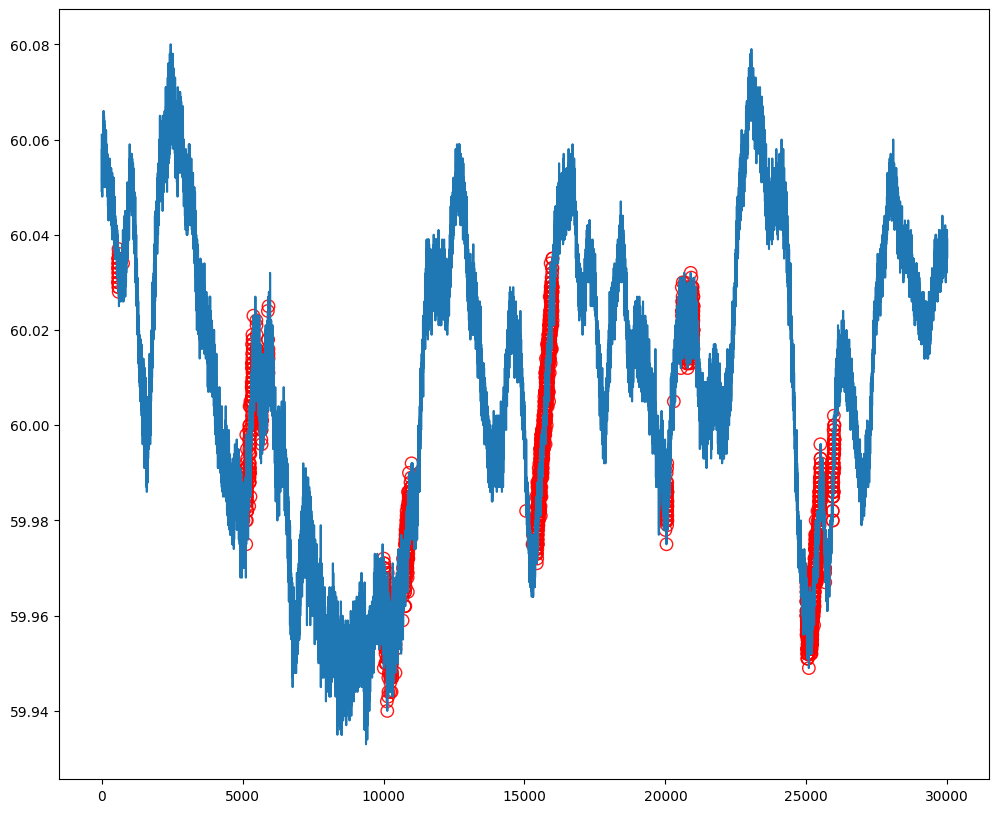

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.plot(np.arange(0, len(pmu_test)), pmu_test["Frequency"])
plt.scatter(
    np.arange(0, len(pmu_test))[outliers_idices.astype(int)],
    pmu_test["Frequency"][outliers_idices.astype(int)],
    s=80,
    facecolors="none",
    edgecolors="red",
    alpha=0.9,
)

In [16]:
df = pmu_test.sample(1).drop("timestamp", axis=1)
# Loop through each row and column in the DataFrame to insert into the database
for col in df.columns:
    for index, value in df[col].items():
        print(datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3], col, value)


2024-10-14 13:06:47.744 Frequency 60.0260009765625
2024-10-14 13:06:47.744 DeFrequency -0.0049972534179687
2024-10-14 13:06:47.744 Voltage_R 66.27881622314453
2024-10-14 13:06:47.744 Voltage_R_Angle -36.67999414499023
2024-10-14 13:06:47.744 Voltage_S 66.39848327636719
2024-10-14 13:06:47.744 Voltage_S_Angle -36.659991936005845
2024-10-14 13:06:47.744 Voltage_T 66.41828155517578
2024-10-14 13:06:47.744 Voltage_T_Angle -36.63999314211605
2024-10-14 13:06:47.744 Voltage_Z 66.24386596679688
2024-10-14 13:06:47.744 Voltage_Z_Angle -36.659991936005845
2024-10-14 13:06:47.744 Current_I1 0.6713958978652954
2024-10-14 13:06:47.744 Current_I1_Angle 140.79997841874405
2024-10-14 13:06:47.744 Current_I2 0.6702679991722107
2024-10-14 13:06:47.744 Current_I2_Angle 140.72996897975142
2024-10-14 13:06:47.744 Current_I3 0.6707919836044312
2024-10-14 13:06:47.744 Current_I3_Angle 140.73995471631798
2024-10-14 13:06:47.744 Current_I4 0.6705024838447571
2024-10-14 13:06:47.744 Current_I4_Angle 140.739982

In [11]:
from datetime import datetime
datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]

'2024-10-14 13:05:48.187'

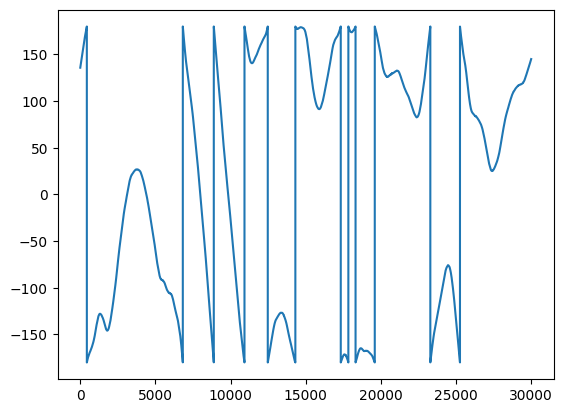

In [39]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0, len(pmu_test)), pmu_test["Current_I1_Angle"])

<Axes: >

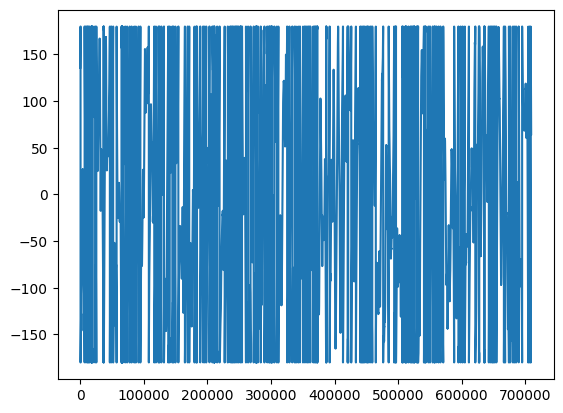

In [41]:
pmu_data["Current_I1_Angle"].plot()